In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm
from sklearn import tree
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [2]:
# read the csv file
data_file = pd.read_csv('CovidSurveillance.csv')
# the non essential columns are ignored
df = data_file.drop(columns=['cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'current_status'])

In [4]:
df.head(7)

,cdc_case_earliest_dt,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/14,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",Unknown,No,No,No
1,2020/07/15,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No,No,No,No
2,2020/06/23,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No,No,No,No
3,2020/05/09,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No,No,No,No
4,2020/10/20,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No,No,No,No
5,2020/05/30,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No,No,No,No
6,2020/12/24,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No,No,No,No


**Handling Missing Data**




In [8]:
df.describe()

,cdc_case_earliest_dt,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
count,901599,901599,901599,901599,901599,901599,901599,901599
unique,471,2,10,9,4,2,2,2
top,2020/11/09,Female,20 - 29 Years,"White, Non-Hispanic",No,No,No,No
freq,5865,479010,149512,470395,746708,856413,853653,520132


In [9]:
# where missing values in csv file are detected.
for column in df:
    sol = df[column].unique() #sol means solution / result
    if column == 'cdc_case_earliest_dt':
        continue
    else:
        print(column)
        print(sol)

sex
['Female' 'Male']
age_group
['0 - 9 Years' '10 - 19 Years' '20 - 29 Years' '30 - 39 Years'
 '40 - 49 Years' '50 - 59 Years' '60 - 69 Years' '70 - 79 Years'
 '80+ Years' 'Missing']
race_ethnicity_combined
['American Indian/Alaska Native, Non-Hispanic' 'Unknown' 'Hispanic/Latino'
 'Black, Non-Hispanic' 'Asian, Non-Hispanic' 'Missing'
 'Multiple/Other, Non-Hispanic'
 'Native Hawaiian/Other Pacific Islander, Non-Hispanic'
 'White, Non-Hispanic']
hosp_yn
['Unknown' 'No' 'Missing' 'Yes']
icu_yn
['No' 'Yes']
death_yn
['No' 'Yes']
medcond_yn
['No' 'Yes']


In [10]:
# the detected missing values are selected and The ratio of missing values has been calculated and printed on the screen
missing_na_values = df[(df['race_ethnicity_combined']=='Missing') | (df['race_ethnicity_combined']=='Unknown') |
               (df['age_group']=='Missing') | (df['hosp_yn']=='Missing') | (df['hosp_yn']=='Unknown')]
print("Ratio of the the rows with missing values to the rest is: %" + str(missing_na_values.size*100 / df.size)[0:7])

Ratio of the the rows with missing values to the rest is: %18.0478


In [11]:
# Rows with na values are cleared / deleted
df_2 = df.drop(missing_na_values.index, axis=0).reset_index(drop=True)


In [12]:
# After deleting the na values, the data set was checked. It was checked whether there is a value of na in it.
for column in df_2:
    sol = df_2[column].unique()
    if column == 'cdc_case_earliest_dt':
        continue
    else:
        print(column)
        print(sol)

sex
['Female' 'Male']
age_group
['0 - 9 Years' '10 - 19 Years' '20 - 29 Years' '30 - 39 Years'
 '40 - 49 Years' '50 - 59 Years' '60 - 69 Years' '70 - 79 Years'
 '80+ Years']
race_ethnicity_combined
['American Indian/Alaska Native, Non-Hispanic' 'Hispanic/Latino'
 'Black, Non-Hispanic' 'Asian, Non-Hispanic'
 'Multiple/Other, Non-Hispanic'
 'Native Hawaiian/Other Pacific Islander, Non-Hispanic'
 'White, Non-Hispanic']
hosp_yn
['No' 'Yes']
icu_yn
['No' 'Yes']
death_yn
['No' 'Yes']
medcond_yn
['No' 'Yes']


**Data Exploration**

In [13]:
# datetime objects are easier to work with graphics.
# That's why date data was converted to datetime
df_3 = df_2
df_3['date'] = pd.to_datetime(df_3['cdc_case_earliest_dt'],format='%Y/%m/%d')
df_3 = df_3.drop(columns='cdc_case_earliest_dt')

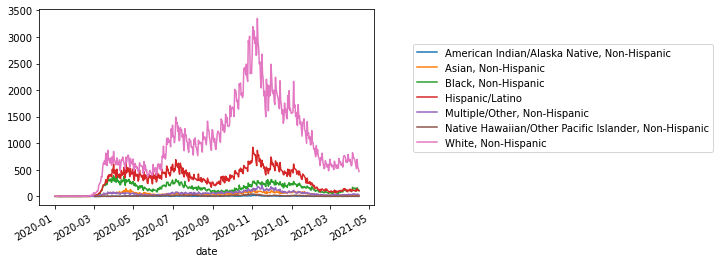

In [14]:
# The case is grouped according to the patient's race, ie ethnicity. 
# The number of cases for each group is plotted on a daily basis.
df_patient = df_3.groupby(['race_ethnicity_combined','date'])
keys = df_patient.groups.keys()
temp = df_patient.size().reset_index().rename(columns={0:'count'}).groupby('race_ethnicity_combined')
fig, ax = plt.subplots()

for key, graph in temp:
    ax = graph.plot(ax=ax, kind='line', x='date', y='count', label=key)

# This places the legend outside of the graph
plt.legend(bbox_to_anchor=(1.1, 0.85))
plt.show()

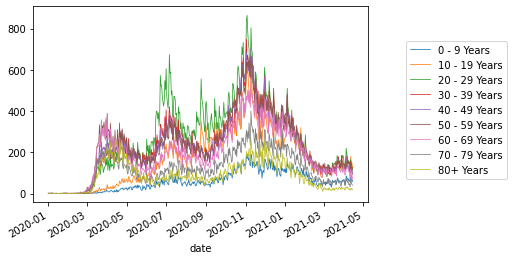

In [15]:
# Cases are grouped by age group of the patient
df_patient = df_3.groupby(['age_group','date'])
keys = df_patient.groups.keys()
temp = df_patient.size().reset_index().rename(columns={0:'count'}).groupby('age_group')
fig, ax = plt.subplots()

for key, graph in temp:
    ax = graph.plot(ax=ax, kind='line', x='date', y='count', label=key,linewidth=0.75)

# This places the legend outside of the graph
plt.legend(bbox_to_anchor=(1.1, 0.85))
plt.show()

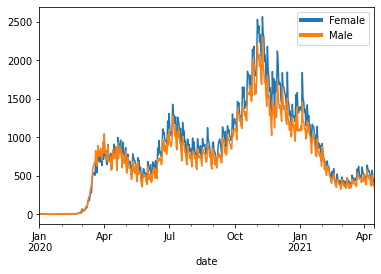

In [17]:
df_patient = df_3.groupby(['sex','date'])
keys = df_patient.groups.keys()
temp = df_patient.size().reset_index().rename(columns={0:'count'}).groupby('sex')
fig, ax = plt.subplots()

for key, grp in temp:
    ax = grp.plot(ax=ax, kind='line', x='date', y='count', label=key)

leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4)
    
plt.show()

**Pie Charts**

With Pie Chart, all disease rates by races and disease distribution by all age groups are shown.

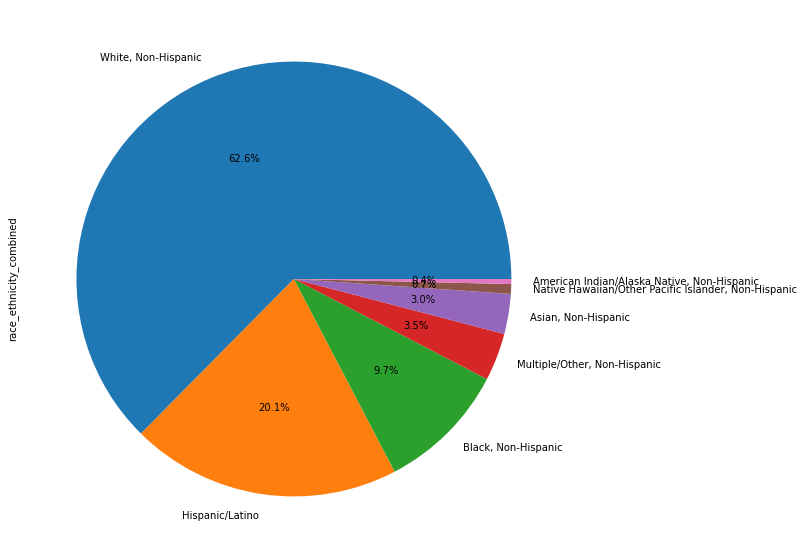

In [18]:
# Chart showing how many total cases the race
# The effect of the disease on different races is shown. This graph is created over flat numbers.
# Not correlated with racial proportions of the population
figure(figsize=(15, 10))
df_3['race_ethnicity_combined'].value_counts().plot.pie(autopct='%1.1f%%')


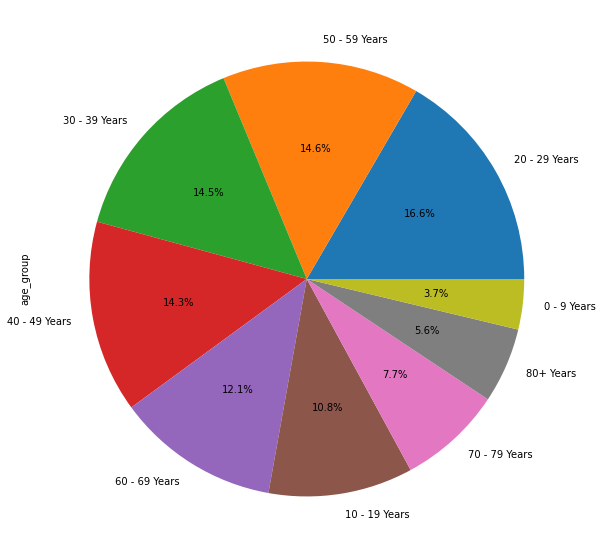

In [19]:
# Chart showing how many total cases the age
# This graphic shows the distribution of covid among age groups.
figure(figsize=(20, 10))
df_3['age_group'].value_counts().plot.pie(autopct='%1.1f%%')

With bar container, the distribution of the disease by ethnicity, the distribution by age, the effect of pre-existing medical conditions on the disease, whether the patient was admitted to the intensive care unit and the mortality rates were visualized. 

**Bar Container**

In [20]:
# The names of the race / ethnicity are written side by side in bar charts and histograms
# Names are shortened to make them look better in the chart
# c means convertion
c= {'American Indian/Alaska Native, Non-Hispanic':'Native', 'Hispanic/Latino':'Hispanic',
       'Black, Non-Hispanic':'Black', 'Asian, Non-Hispanic':'Asian',
       'Multiple/Other, Non-Hispanic':'Other',
       'Native Hawaiian/Other Pacific Islander, Non-Hispanic':'Pacific Islander',
       'White, Non-Hispanic':'White'}
df_bc = df_3.copy()
df_bc['race_ethnicity_combined'] = df_bc['race_ethnicity_combined'].map(c)

<BarContainer object of 7 artists>

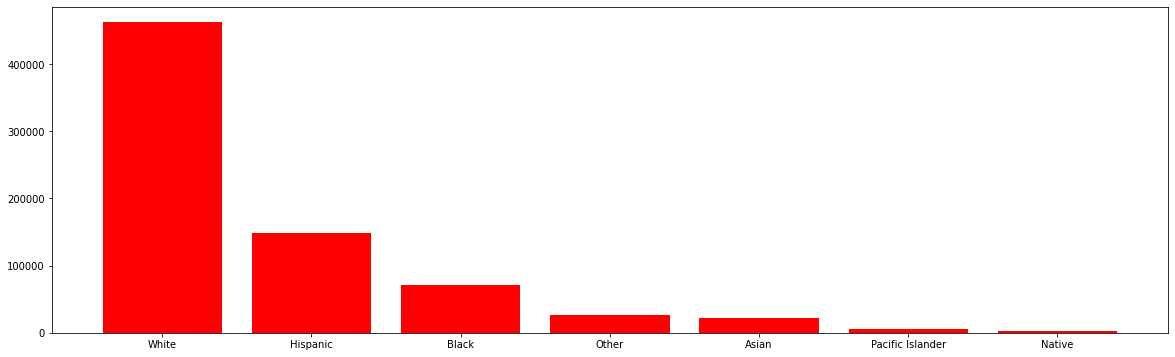

In [21]:
figure(figsize=(20, 6))
df_bc1 = df_bc['race_ethnicity_combined'].value_counts().reset_index()
plt.bar(df_bc1['index'],df_bc1['race_ethnicity_combined'],label="Red Bar", color='r')

<BarContainer object of 9 artists>

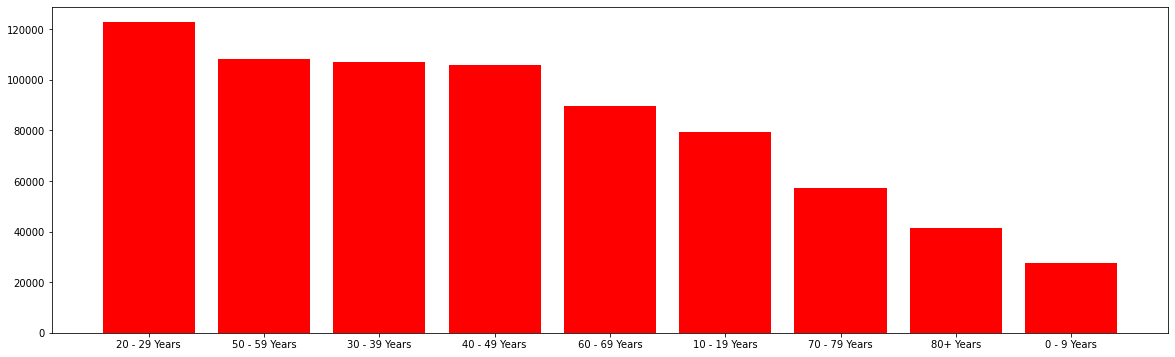

In [22]:
figure(figsize=(20, 6))
df_bc1 = df_bc['age_group'].value_counts().reset_index()
plt.bar(df_bc1['index'],df_bc1['age_group'],label="Red Bar", color='r')

<BarContainer object of 2 artists>

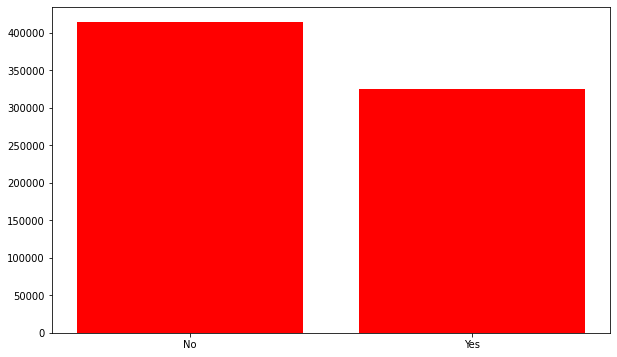

In [23]:
figure(figsize=(10, 6))
df_bc2 = df_bc['medcond_yn'].value_counts().reset_index()
plt.bar(df_bc2['index'],df_bc2['medcond_yn'],label="Red Bar", color='r')

<BarContainer object of 2 artists>

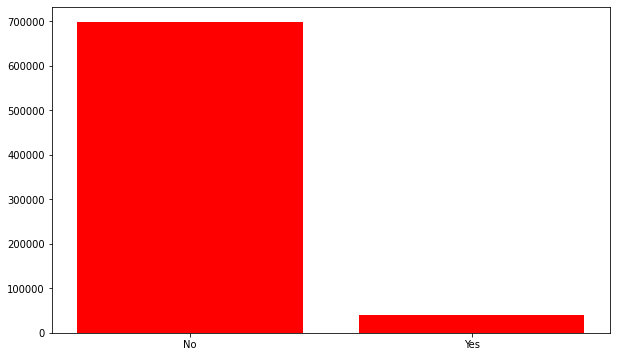

In [24]:
figure(figsize=(10, 6))
df_bc3 = df_bc['icu_yn'].value_counts().reset_index()
plt.bar(df_bc3['index'],df_bc3['icu_yn'],label="Red Bar", color='r')

<BarContainer object of 2 artists>

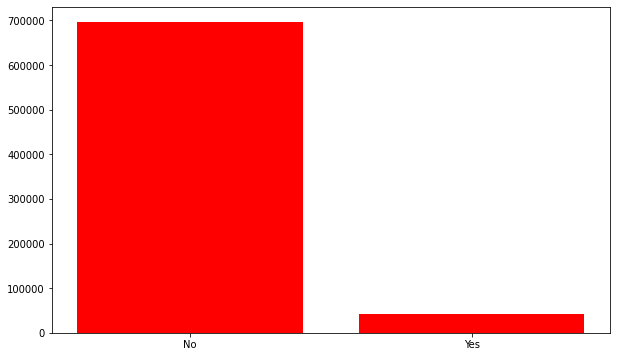

In [25]:
figure(figsize=(10, 6))
df_bc4 = df_bc['death_yn'].value_counts().reset_index()
plt.bar(df_bc4['index'],df_bc4['death_yn'],label="Red Bar", color='r')

**Count Plot Graphs**

In Count Plot graphs, the distribution of medical conditions by gender, the distribution of death rates by gender, the ratio of death rates to the distribution of medical conditions are shown. Finally, the ratio of death rates to age distribution is shown.

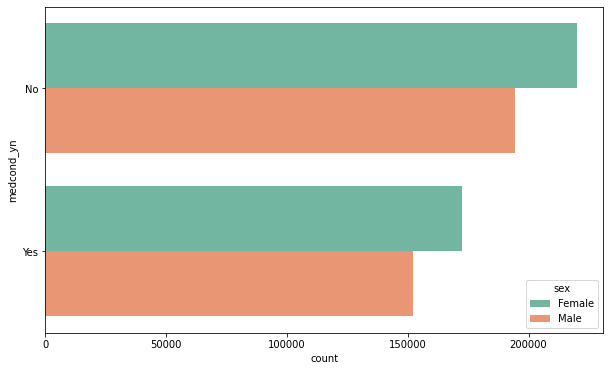

In [26]:
# This chart shows the distribution of medical conditions by gender (men and women)
figure(figsize=(10, 6))
sns.countplot(y="medcond_yn",hue ='sex',data=df_3, palette="Set2")


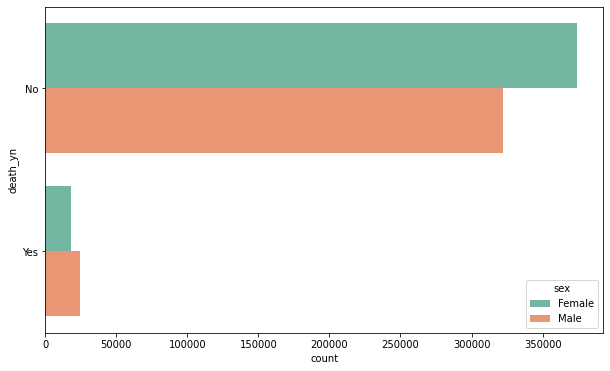

In [27]:
# This graph shows the mortality rate between men and women.
# Compared to the previous chart;
# Men appear to have higher mortality rates despite having less medical conditions than women. 
# This means a possible biological difference versus covid
figure(figsize=(10, 6))
sns.countplot(y="death_yn",hue ='sex',data=df_3,palette="Set2")


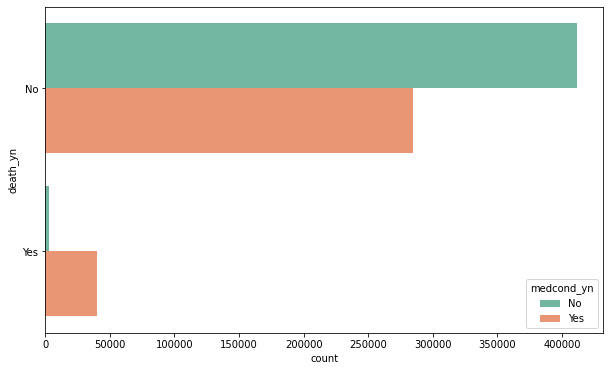

In [28]:
# death stability of medical conditions can be seen here.
figure(figsize=(10, 6))
sns.countplot(y="death_yn",hue ='medcond_yn',data=df_3, palette="Set2")


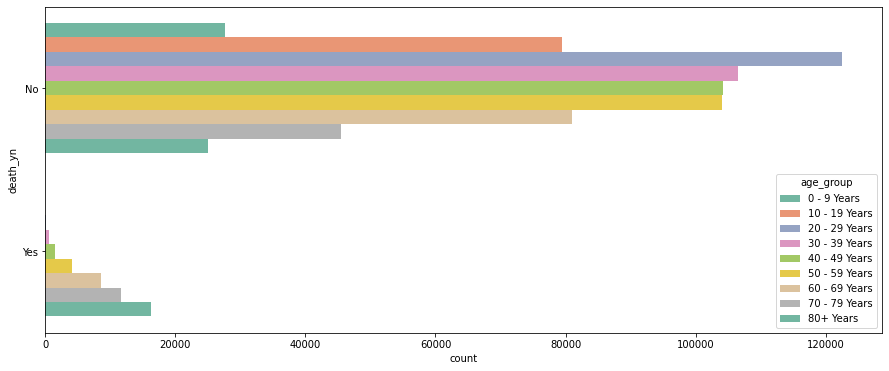

In [29]:
# This graph shows that although higher age groups have low case numbers, they are much more likely to die.
figure(figsize=(15, 6))
sns.countplot(y="death_yn",hue ='age_group',data=df_3, palette="Set2")


With heatmaps, the case distribution of both age groups and races, the relationship between the hospitalized patient and the patient hospitalized in intensive care, hospitalization and death can be seen.

**Heatmaps**

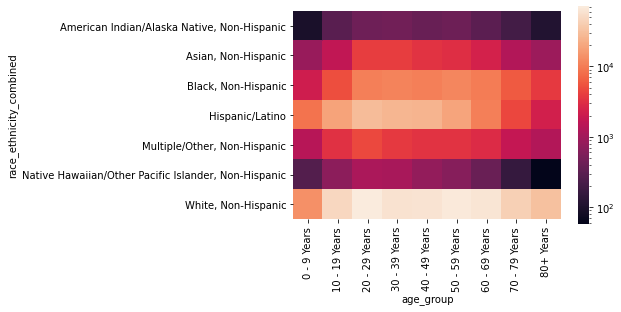

In [30]:
# Here shows the case distribution of both age groups and races. From this, it appears that most cases occur at similar ages for all races.
df_H = df_3.groupby(['race_ethnicity_combined','age_group']).size().unstack().fillna(1)
log_norm = LogNorm(vmin=df_H.min().min(), vmax=df_H.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(df_H.min().min())), 1+math.ceil(math.log10(df_H.max().max())))]

ax = sns.heatmap(df_H, square=True,norm=log_norm,cbar_kws={"ticks": cbar_ticks})
plt.show()

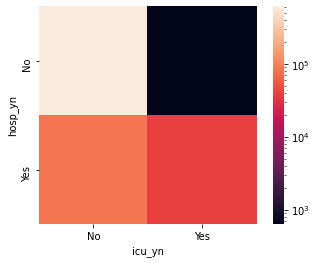

In [31]:
# It shows the relationship between a patient hospitalized and a patient placed in the intensive care unit. The lower right of the upper right, although obvious, indicates that a 
# small number of hospitalized patients are placed in the icu, but the difference is not too much
df_H = df_3.groupby(['hosp_yn','icu_yn']).size().unstack().fillna(1)
log_norm = LogNorm(vmin=df_H.min().min(), vmax=df_H.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(df_H.min().min())), 1+math.ceil(math.log10(df_H.max().max())))]

ax = sns.heatmap(df_H, square=True,norm=log_norm,cbar_kws={"ticks": cbar_ticks})
plt.show()

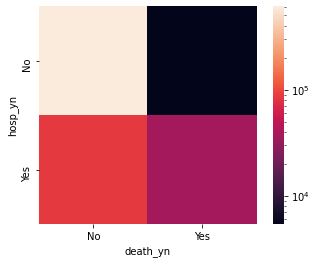

In [32]:
# The relationship between hospitalization and death can be seen. Almost all deaths occurred in hospitalized patients, 
# which means that patients with severe symptoms were properly noticed and hospitalized.
df_H = df_3.groupby(['hosp_yn','death_yn']).size().unstack().fillna(1)
log_norm = LogNorm(vmin=df_H.min().min(), vmax=df_H.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(df_H.min().min())), 1+math.ceil(math.log10(df_H.max().max())))]

ax = sns.heatmap(df_H, square=True,norm=log_norm,cbar_kws={"ticks": cbar_ticks})
plt.show()

**Using the Decision Tree to Predict a Case's Death Status**

In [33]:
# To use a Decision tree, you need integer columns of data type. That's why the columns have been converted to integers.
start = df_3['date'].min()
def time_diff(current):
    return current.day-start.day
# c1 means convert1
c1 = {'Female':0, 'Male':1}
c2 = {'0 - 9 Years':0, '10 - 19 Years':1, '20 - 29 Years':2, '30 - 39 Years':3,
       '40 - 49 Years':4, '50 - 59 Years':5, '60 - 69 Years':6, '70 - 79 Years':7,
       '80+ Years':8}
c3 = {'American Indian/Alaska Native, Non-Hispanic':0, 'Hispanic/Latino':1,
       'Black, Non-Hispanic':2, 'Asian, Non-Hispanic':3, 'Multiple/Other, Non-Hispanic':4,
       'Native Hawaiian/Other Pacific Islander, Non-Hispanic':5,'White, Non-Hispanic':6}
c4 = {'No':0, 'Yes':1}

In [34]:
df_T = df_3.copy()
# df_T['sex'] = df_T['Sex'].map({'Female': 0,'Male': 1})
df_T['sex']=df_T['sex'].map(c1)
df_T['age_group']=df_T['age_group'].map(c2)
df_T['race_ethnicity_combined']=df_T['race_ethnicity_combined'].map(c3)
df_T['hosp_yn']=df_T['hosp_yn'].map(c4)
df_T['icu_yn']=df_T['icu_yn'].map(c4)
df_T['death_yn']=df_T['death_yn'].map(c4)
df_T['medcond_yn']=df_T['medcond_yn'].map(c4)
df_T['time_passed'] = df_T['date'].apply(time_diff)
df_T = df_T.drop(columns = 'date')

In [35]:
X = df_T.drop(columns='death_yn')
y = df_T['death_yn']

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train with Decision tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9536325249025552

In [36]:
# guessing the sex of the patients is higher than 0.5, but not significantly higher.
X = df_T.drop(columns='sex')
y = df_T['sex']

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train with Decision tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.542821567778259


**Using Decision Tree to Predict Death in a Day**

In [37]:
df_T2 = df_T.groupby(['time_passed','age_group','sex','race_ethnicity_combined']).sum().reset_index()

X = df_T2.drop(columns='death_yn')
y = df_T2['death_yn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.42857142857142855

**Hypothesis testing**

In [39]:
convert = {'No':0, 'Yes':1}
dfHT = df_3[['date','race_ethnicity_combined','death_yn']].copy()
dfHT['death_yn'] = dfHT['death_yn'].map(convert)
dfHT1 = dfHT[dfHT['race_ethnicity_combined']=='Black, Non-Hispanic'].drop(columns='race_ethnicity_combined').groupby('date').mean()
dfHT2 = dfHT[dfHT['race_ethnicity_combined']!='Black, Non-Hispanic'].drop(columns='race_ethnicity_combined').groupby('date').mean()
p = stats.ttest_ind(dfHT1,dfHT2,equal_var=False).pvalue
print('p value = ' + str(p[0]))

p value = 2.8504861704553004e-08


In [40]:
convert = {'No':0, 'Yes':1}
dfHT = df_3[['date','sex','death_yn']].copy()
dfHT['death_yn'] = dfHT['death_yn'].map(convert)
dfHT1 = dfHT[dfHT['sex']=='Female'].drop(columns='sex').groupby('date').mean()
dfHT2 = dfHT[dfHT['sex']=='Male'].drop(columns='sex').groupby('date').mean()
p = stats.ttest_ind(dfHT1,dfHT2,equal_var=False).pvalue
print('p value = ' + str(p[0]))

print('mean death ratio for men per month:   ' + str(dfHT2.mean().death_yn))
print('mean death ratio for women per month: ' + str(dfHT1.mean().death_yn))

p value = 0.0030387521113432133
mean death ratio for men per month:   0.09513818795753115
mean death ratio for women per month: 0.07164078228689721
